Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


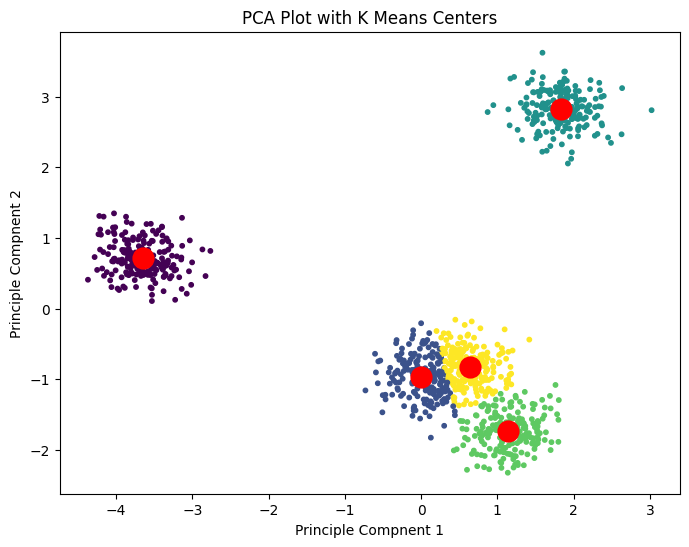

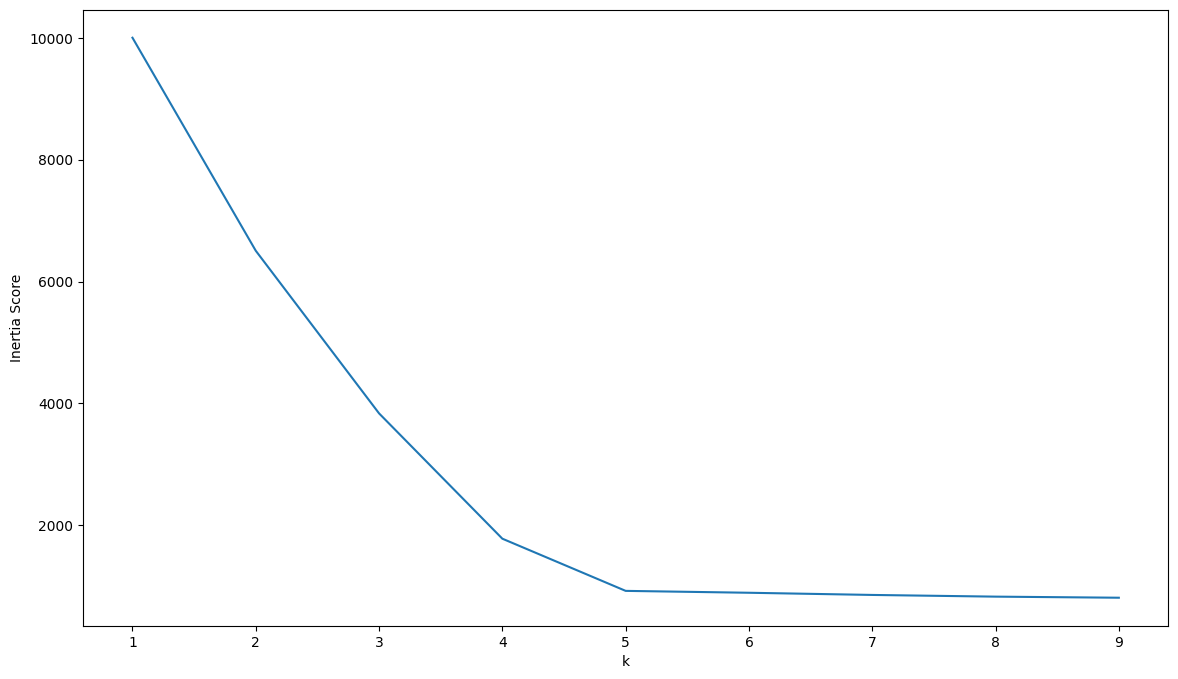

   k       inertia
0  1  10000.000000
1  2   6504.839876
2  3   3836.377137
3  4   1780.417264
4  5    924.315996
5  6    893.385637
6  7    857.632929
7  8    829.729937
8  9    811.973041


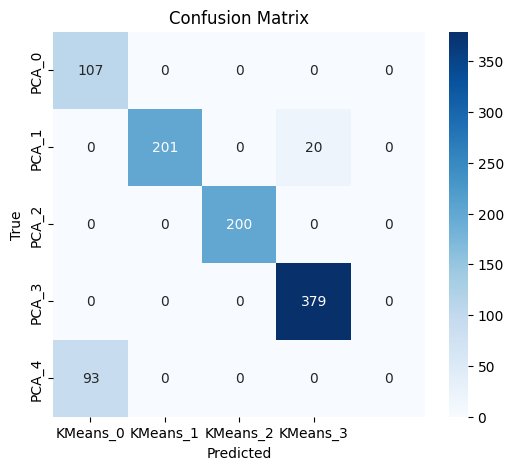

In [ ]:
#PCA Clustering
X_PCA = PCA(n_components=2).fit_transform(X)

#kMean Model
kmeans_model = KMeans(init='k-means++', n_clusters=5, n_init=10, random_state=42)
kmeans_model.fit(X_PCA)

#Lables and Centers
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

#Plot PCA points colored by cluster
plt.figure(figsize=(8,6))
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=169, linewidths=3, color='red', zorder=10)
plt.title("PCA Plot with K Means Centers")
plt.xlabel("Principle Compnent 1")
plt.ylabel("Principle Compnent 2")
plt.show()

#Elbow Analysis
ks = range(1,10)
scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    y_pred = model.fit_predict(X)
    scores.append(-model.score(X))

#Plot Elbow Curve
fig = plt.figure(figsize=(14, 8))
plt.plot(ks, scores)
plt.ylabel('Inertia Score')
plt.xlabel('k')
plt.show()

results = pd.DataFrame({"k": ks, "inertia": scores})
print(results)

#Confusion Matrix
pca_kmeans = KMeans(n_clusters=5, random_state=42)
y_true = pca_kmeans.fit_predict(X_PCA)
y_pred = kmeans_model.labels_

#Match Predictions and PCA Clusters
mapped_labels = np.zeros_like(y_pred)
for cluster in np.unique(y_pred):
    mask = (y_pred == cluster)
    mapped_labels[mask] = mode(y_true[mask], keepdims=True)[0]

cm = confusion_matrix(y_true, mapped_labels)

#Confusion Matrix Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"KMeans_{i}" for i in np.unique(mapped_labels)],
            yticklabels=[f"PCA_{i}" for i in np.unique(y_true)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 2. Clustering Fashion-MNIST using $k$-means

In [8]:
#Note OpenML went down while I was trying to complete this assignment so I used chatGPT to write the code in the cell below to obtain the dataset via another source

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

KeyboardInterrupt: 

In [9]:
#This code was written by chatGPT to obtain the dataset as openML was down

import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST directly from Keras
# Classes (0–9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Combine train and test sets
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

# Flatten 28x28 images into 784-dimensional vectors
X = X.reshape(X.shape[0], -1)

# Optional: scale/standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X type and shape:", type(X_scaled), X_scaled.shape)
print("y type and shape:", type(y), y.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X type and shape: <class 'numpy.ndarray'> (70000, 784)
y type and shape: <class 'numpy.ndarray'> (70000,)


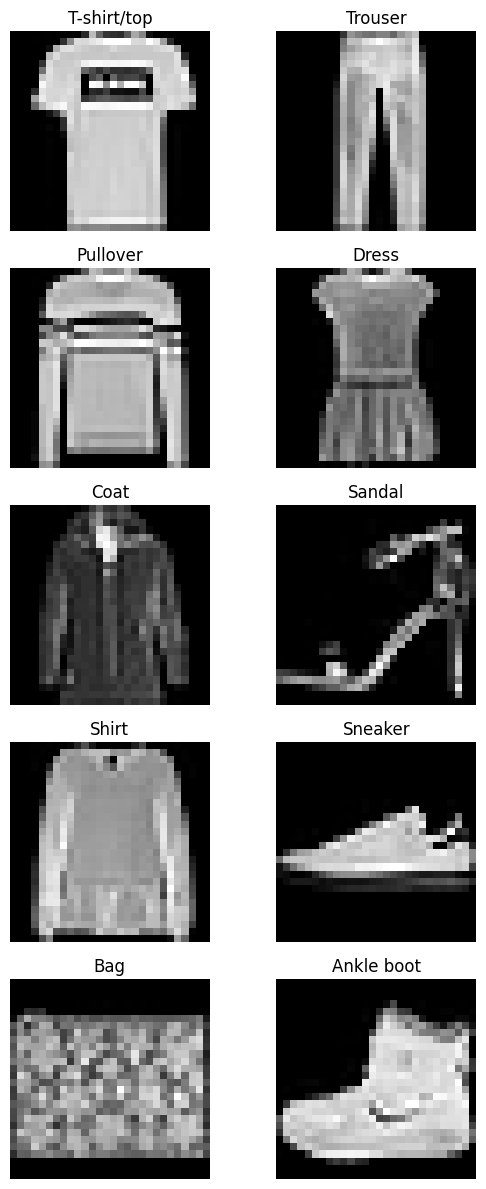

In [10]:
#Viszuliaing Dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axes = plt.subplots(5, 2, figsize=(6, 12))
axes = axes.ravel()

for i in range(10):
    idx = np.where(y == i)[0][0]
    img = X[idx].reshape(28, 28)
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(class_names[i])
    axes[i].axis("off")
plt.tight_layout()
plt.show()

Reduced data shape: (10000, 50)
KMeans Inertia: 2784621.5936396336


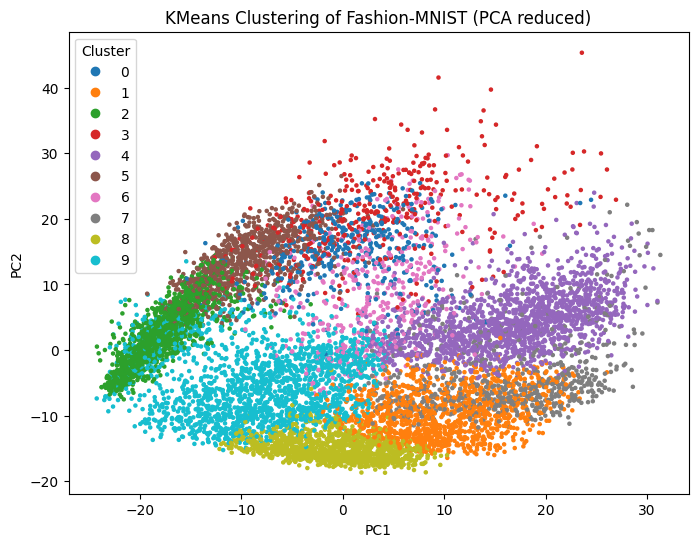

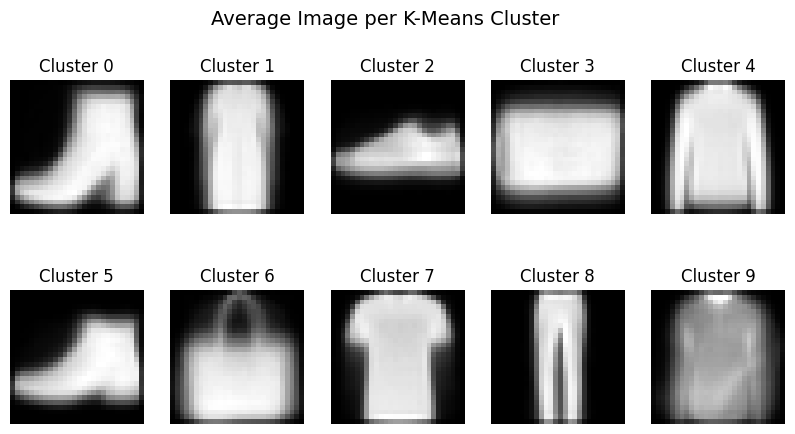

In [12]:
#Sample and Scale Data for Faster Compute
n_samples = 10000
rng = np.random.default_rng(42)
subset_idx = rng.choice(len(X), n_samples, replace=False)
X = X[subset_idx]
y = y[subset_idx]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA for visualization and KMeans
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Reduced data shape:", X_pca.shape)

k = 10
kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
labels = kmeans.fit_predict(X_pca)

print("KMeans Inertia:", kmeans.inertia_)

#Visualize using PCA
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab10", s=5)
plt.title("KMeans Clustering of Fashion-MNIST (PCA reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

#Determining Cluster Identities
cluster_means = []
for i in range(10):
    mean_img = X[labels == i].mean(axis=0).reshape(28, 28)
    cluster_means.append(mean_img)

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(cluster_means[i], cmap='gray')
    plt.title(f"Cluster {i}")
    plt.axis('off')
plt.suptitle("Average Image per K-Means Cluster", fontsize=14)
plt.show()

# 3. Dimensionality reduction for Fashion-MNIST

In [ ]:
# your code here
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import pairwise_distances

# 1. Load Fashion-MNIST
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

# Subsample to make pairwise distances tractable
n_samples = 2000
rng = np.random.default_rng(42)
subset_idx = rng.choice(len(X), n_samples, replace=False)
X = X[subset_idx]

# 2. Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Compute pairwise distances in original space
D_original = pairwise_distances(X_scaled, metric="euclidean")

# 4. Define target dimensions
dims = [10, 20, 50, 100, 200]
corr_pca = []
corr_rp = []

# 5. Loop over target dimensions
for k in dims:
    # PCA
    pca = PCA(n_components=k, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    D_pca = pairwise_distances(X_pca, metric="euclidean")
    corr_pca.append(np.corrcoef(D_original.ravel(), D_pca.ravel())[0,1])

    # Random Projection
    rp = GaussianRandomProjection(n_components=k, random_state=42)
    X_rp = rp.fit_transform(X_scaled)
    D_rp = pairwise_distances(X_rp, metric="euclidean")
    corr_rp.append(np.corrcoef(D_original.ravel(), D_rp.ravel())[0,1])

# 6. Plot results
plt.figure(figsize=(8,6))
plt.plot(dims, corr_pca, marker="o", label="PCA")
plt.plot(dims, corr_rp, marker="s", label="Random Projection")
plt.xlabel("Target Dimension k")
plt.ylabel("Correlation with Original Distances")
plt.title("PCA vs Random Projection on Fashion-MNIST")
plt.legend()
plt.grid(True)
plt.show()


# 4. Clustering Fashion-MNIST using spectral clustering

In [ ]:
# your code here